In [2]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools
import os
import math
from datetime import datetime, timedelta
import requests
from itertools import combinations
import statsmodels 
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.datasets import make_regression
import seaborn as sns

from datetime import datetime, timedelta


quandl.ApiConfig.api_key = HIDDEN
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)

### FOR REFERENCE WHILE DEVELOPING:
# Ticker = ['BA', 'C', 'DD', 'F', 'GE', 'JPM', 'LOW', 'LUV', 'MAR', 'T', 'WFC', 'XOM']

Zachary Mariani's 

## Homework: Robust Regression and Inter-Asset Beta 
### Due May 13 at 11PM Chicago Time

### Step 1: Prepare the Data

In [3]:
#fixed start and end dates based on the start and end of the CDS data!
start_date = '2018-01-01'
end_date = '2021-04-30'

#generate Wednesdays 
start, end = datetime(2018, 1, 1), datetime(2021, 4, 30)
days = (start + timedelta(days=i) for i in range((end - start).days + 1))
wednesdays = [d for d in days if d.weekday() in [2] ]
wednesdays_strs = [day.strftime("%Y-%m-%d") for day in wednesdays]


In [4]:
#import all of the CDS data 
data = pd.read_table('/Users/zachmariani/Downloads/Liq5YCDS.delim')

In [5]:
#set up a dict for the CDS data by each ticker 

wed_sr = np.array(wednesdays_strs)
wed_df = pd.DataFrame(index=wed_sr)

CDS_data = {}
for ticker in data['ticker'].unique():
    try:
        #filter by matching ticker
        temp = data.loc[(data['ticker'] == ticker)]
        temp.set_index('date', inplace=True)
        #get only the Wednesdays 
        temp = temp.loc[temp.index.isin(wednesdays_strs)]
        #ffill Wednesdays which are missing data 
        temp = wed_df.merge(temp, left_index=True, right_index = True, how = 'outer').fillna(method = 'ffill')

        CDS_data[ticker] = temp
    except Exception as e:
        print('Failed to get CDS data: ', e)

In [6]:
#Generate a dictionary of all of the EOD data for the corresponding equities from Quandl
wed_sr = np.array(wednesdays)
wed_df = pd.DataFrame(index=wed_sr)

EOD_data = {}
for ticker in data['ticker'].unique():
    try:
        temp = quandl.get('EOD/' + ticker, start_date = start_date, end_date = end_date, column_index = '11')
        #get only the Wednesdays 
        temp = temp.loc[temp.index.isin(wednesdays_strs)]   
        #ffill Wednesdays which are missing data 
        temp = wed_df.merge(temp, left_index=True, right_index = True, how = 'outer').fillna(method = 'ffill')
        EOD_data[ticker] = temp
        
    except Exception as e:
        print('Failed to get EOD data: ', e)

In [7]:
#get the percent changes from one week to the next 
for key, value in CDS_data.items():
    value['spread5y_returns'] = value['spread5y'].pct_change(1)

for key, value in EOD_data.items():
    value['returns'] = value['Adj_Close'].pct_change(1)

In [8]:
#get the arithmetic average of all CDS returns 
r_index = 0 
n = 0
for key, value in CDS_data.items(): 
    r_index += CDS_data[key]['spread5y_returns']
    n += 1
r_index = (r_index / n)

### Step 2: Generating Regressions 

First, we are going to generate a basic OLS regression which does not take any robustness factors into account. We are just going to do a very similar basic OLS and then an OLS which forces the intercept to 0. 

In [9]:
# OLS

# Everything we have to keep track of!
regression_type_lst = []
ticker_lst = []
training_start_lst = []
training_end_lst = []
testing_start_lst = []
testing_end_lst = []
A_or_B_lst = []
mean_abs_error_lst = []
mean_sq_error_lst = []
raw_errors_lst = []
scale_lst = []
distance_lst = []
rsquared_lst = []
param_equity_lst = []
param_index_lst = []
param_intercept_lst = []

for intercept in ['A', 'B']:

    # For every ticker 
    for ticker in data['ticker'].unique():

        # For every set of training data 
        for training_start in range (1, 153):
            training_end = training_start + 16

            in_sample = wednesdays_strs[training_start:training_end]
            df_for_model = pd.DataFrame()
            df_for_model['CDS'] = CDS_data[ticker].loc[in_sample]['spread5y_returns']
            df_for_model['Equity'] = EOD_data[ticker].loc[in_sample]['returns'].values
            df_for_model['Index'] = r_index[in_sample]

            if intercept == 'A': 
                model = statsmodels.formula.api.ols('CDS ~ Equity + Index -1', data = df_for_model)
             
            if intercept == 'B':
                model = statsmodels.formula.api.ols('CDS ~ Equity + Index', data = df_for_model)
                
            results = model.fit()
            scale = results.scale
            rsquared = results.rsquared 
            params = results.params

            try:
                test = params['Intercept']
            except: 
                params['Intercept'] = 0

            # For all four of the possible testing windows 
            for testing_delta in range (1, 5):
                distance_lst.append(testing_delta)

                testing_start = training_end 
                testing_end = training_end + testing_delta

                out_of_sample = wednesdays_strs[testing_start:testing_end]

                #build out the model 
                df_to_model = pd.DataFrame()
                df_to_model['CDS'] = CDS_data[ticker].loc[out_of_sample]['spread5y_returns']
                df_to_model['Equity'] = EOD_data[ticker].loc[out_of_sample]['returns'].values
                df_to_model['Index'] = r_index[out_of_sample]
                df_to_model['Prediction'] = \
                    params['Intercept'] +\
                    params['Equity'] * df_to_model['Equity'] + \
                    params['Index'] * df_to_model['Index']

                #calculate the errors
                mean_abs_error = metrics.mean_absolute_error(df_to_model['CDS'], df_to_model['Prediction'])
                mean_sq_error = metrics.mean_squared_error(df_to_model['CDS'], df_to_model['Prediction'])
                raw_errors = (df_to_model['Prediction'] - df_to_model['CDS']).values

                #keep track of everything 
                regression_type_lst.append('OLS')
                ticker_lst.append(ticker)
                training_start_lst.append(training_start)
                training_end_lst.append(training_end)
                testing_start_lst.append(testing_start)
                testing_end_lst.append(testing_end)
                A_or_B_lst.append(intercept)
                mean_abs_error_lst.append(mean_abs_error)
                mean_sq_error_lst.append(mean_sq_error)
                raw_errors_lst.append(raw_errors)
                scale_lst.append(scale)
                rsquared_lst.append(rsquared)

                param_equity_lst.append(params['Equity'])
                param_index_lst.append(params['Index'])
                param_intercept_lst.append(params['Intercept'])


In [10]:
#generate the OLS DataFrame 
OLS = pd.DataFrame(
        {'Regression Type': regression_type_lst, 
        'Distance' : distance_lst,
        'Ticker' : ticker_lst, 
        'Training Start': training_start_lst, 
        'Training End' : training_end_lst, 
        'Testing Start' : testing_start_lst, 
        'Testing End' : testing_end_lst, 
        'A or B' : A_or_B_lst, 
        'Beta Equity' : param_equity_lst,
        'Beta Index' : param_index_lst, 
        'Beta Intercept' :param_intercept_lst, 
        'Mean Abs Error' : mean_abs_error_lst, 
        'Mean Sq Error' : mean_sq_error_lst, 
        'Raw Errors': raw_errors_lst,
        'Scale' : scale_lst,
        'R-Squared': rsquared_lst}
)

In [11]:
OLS.head()

,Regression Type,Distance,Ticker,Training Start,Training End,Testing Start,Testing End,A or B,Beta Equity,Beta Index,Beta Intercept,Mean Abs Error,Mean Sq Error,Raw Errors,Scale,R-Squared
0,OLS,1,BA,1,17,17,18,A,-0.169914,1.419176,0.0,0.012651,0.000160,[-0.012650584080816277],0.002137,0.818942
1,OLS,2,BA,1,17,17,19,A,-0.169914,1.419176,0.0,0.018590,0.000381,"[-0.012650584080816277, -0.02453003290408079]",0.002137,0.818942
2,OLS,3,BA,1,17,17,20,A,-0.169914,1.419176,0.0,0.019769,0.000417,"[-0.012650584080816277, -0.02453003290408079, ...",0.002137,0.818942
3,OLS,4,BA,1,17,17,21,A,-0.169914,1.419176,0.0,0.018883,0.000379,"[-0.012650584080816277, -0.02453003290408079, ...",0.002137,0.818942
4,OLS,1,BA,2,18,18,19,A,-0.073738,1.424431,0.0,0.018618,0.000347,[-0.018617694943201618],0.001980,0.830073


Now that we have the DataFrame for our OLS model, without any adjustments for robustness, we will use the Huber penalty function. 

(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

In [12]:
#again keep track of everything as we go!
regression_type_lst = []
ticker_lst = []
training_start_lst = []
training_end_lst = []
testing_start_lst = []
testing_end_lst = []
A_or_B_lst = []
mean_abs_error_lst = []
mean_sq_error_lst = []
raw_errors_lst = []
scale_lst = []
distance_lst = []
rsquared_lst = []
param_equity_lst = []
param_index_lst = []
param_intercept_lst = []

for intercept in ['A', 'B']:
    for ticker in data['ticker'].unique():

        for training_start in range (1, 153):
            training_end = training_start + 16

            #build the model
            in_sample = wednesdays_strs[training_start:training_end]
            df_for_model = pd.DataFrame()
            df_for_model['CDS'] = CDS_data[ticker].loc[in_sample]['spread5y_returns']
            df_for_model['Equity'] = EOD_data[ticker].loc[in_sample]['returns'].values
            df_for_model['Index'] = r_index[in_sample]

            Y = df_for_model['CDS']
            X = df_for_model[['Equity', 'Index']]

            #get the parameters, I used epsilon as 1.35 because this is the default for a Huber penalty
            if intercept == 'A':
                HReg = HuberRegressor(epsilon = 1.35, fit_intercept = False)
            if intercept == 'B':
                HReg = HuberRegressor(epsilon = 1.35, fit_intercept = True)
                
            huber = HReg.fit(X, Y)
            scale = huber.scale_
            params = huber.coef_ 
            
            try: 
                param_intercept = huber.intercept_
            except: 
                param_intercept = 0
                
            param_equity = huber.coef_[0]
            param_index = huber.coef_[1]
            
            rsquared = huber.score(X,Y)

            for testing_delta in range (1, 5):
                distance_lst.append(testing_delta)

                testing_start = training_end 
                testing_end = training_end + testing_delta

                out_of_sample = wednesdays_strs[testing_start:testing_end]

                #use the parameters to generate the predictions
                df_to_model = pd.DataFrame()
                df_to_model['CDS'] = CDS_data[ticker].loc[out_of_sample]['spread5y_returns']
                df_to_model['Equity'] = EOD_data[ticker].loc[out_of_sample]['returns'].values
                df_to_model['Index'] = r_index[out_of_sample]
                df_to_model['Prediction'] = \
                    param_intercept + \
                    param_equity * df_to_model['Equity'] + \
                    param_index * df_to_model['Index']

                #calculate the errors 
                mean_abs_error = metrics.mean_absolute_error(df_to_model['CDS'], df_to_model['Prediction'])
                mean_sq_error = metrics.mean_squared_error(df_to_model['CDS'], df_to_model['Prediction'])
                raw_errors = (df_to_model['Prediction'] - df_to_model['CDS']).values

                #record everything else
                regression_type_lst.append('Huber')
                ticker_lst.append(ticker)
                training_start_lst.append(training_start)
                training_end_lst.append(training_end)
                testing_start_lst.append(testing_start)
                testing_end_lst.append(testing_end)
                A_or_B_lst.append(intercept)
                mean_abs_error_lst.append(mean_abs_error)
                mean_sq_error_lst.append(mean_sq_error)
                raw_errors_lst.append(raw_errors)
                scale_lst.append(scale)
                rsquared_lst.append(rsquared)

                param_equity_lst.append(param_equity)
                param_index_lst.append(param_index)
                param_intercept_lst.append(param_intercept)


In [13]:
#create the Huber DF 
Huber = pd.DataFrame(
        {'Regression Type': regression_type_lst, 
        'Distance' : distance_lst,
        'Ticker' : ticker_lst, 
        'Training Start': training_start_lst, 
        'Training End' : training_end_lst, 
        'Testing Start' : testing_start_lst, 
        'Testing End' : testing_end_lst, 
        'A or B' : A_or_B_lst, 
        'Beta Equity' : param_equity_lst,
        'Beta Index' : param_index_lst, 
        'Beta Intercept' :param_intercept_lst, 
        'Mean Abs Error' : mean_abs_error_lst, 
        'Mean Sq Error' : mean_sq_error_lst, 
        'Raw Errors': raw_errors_lst,
        'Scale' : scale_lst,
        'R-Squared': rsquared_lst}
        )

In [14]:
Huber.tail()

,Regression Type,Distance,Ticker,Training Start,Training End,Testing Start,Testing End,A or B,Beta Equity,Beta Index,Beta Intercept,Mean Abs Error,Mean Sq Error,Raw Errors,Scale,R-Squared
14587,Huber,4,XOM,151,167,167,171,B,0.227907,0.313302,-0.009088,0.043923,0.002464,"[0.06561301520908064, -0.06843801575833944, -0...",0.008678,0.381406
14588,Huber,1,XOM,152,168,168,169,B,0.267783,0.326815,-0.012287,0.072715,0.005288,[-0.07271533533773084],0.009522,0.355912
14589,Huber,2,XOM,152,168,168,170,B,0.267783,0.326815,-0.012287,0.048957,0.002961,"[-0.07271533533773084, -0.025199623160455032]",0.009522,0.355912
14590,Huber,3,XOM,152,168,168,171,B,0.267783,0.326815,-0.012287,0.040388,0.002154,"[-0.07271533533773084, -0.025199623160455032, ...",0.009522,0.355912
14591,Huber,4,XOM,152,168,168,172,B,0.267783,0.326815,-0.012287,0.031053,0.001618,"[-0.07271533533773084, -0.025199623160455032, ...",0.009522,0.355912


Finally, we will build our Tukey Bisquare penalty function 

(https://www.statsmodels.org/stable/generated/statsmodels.robust.norms.TukeyBiweight.html)


In [15]:
regression_type_lst = []
ticker_lst = []
training_start_lst = []
training_end_lst = []
testing_start_lst = []
testing_end_lst = []
A_or_B_lst = []
mean_abs_error_lst = []
mean_sq_error_lst = []
raw_errors_lst = []
scale_lst = []
distance_lst = []
rsquared_lst = []
param_equity_lst = []
param_index_lst = []
param_intercept_lst = []

for intercept in ['A', 'B']:
    
    for ticker in data['ticker'].unique():

        for training_start in range (1, 153):
            training_end = training_start + 16

            #build the data to run for the model 
            in_sample = wednesdays_strs[training_start:training_end]
            df_for_model = pd.DataFrame()
            df_for_model['CDS'] = CDS_data[ticker].loc[in_sample]['spread5y_returns']
            df_for_model['Equity'] = EOD_data[ticker].loc[in_sample]['returns'].values
            df_for_model['Index'] = r_index[in_sample]
            Y = df_for_model['CDS']
            X = df_for_model[['Equity', 'Index']]
            
            #by default, the Robust Linear Regression Forces constant to 0 
            #so in the B case, we add the constant in 
            if intercept == 'B':
                X = statsmodels.tools.tools.add_constant(X)

            #build the regression, 4.685 is the default for Tukey so we keep it 
            tukey = sm.RLM(Y, X, M = sm.robust.norms.TukeyBiweight(c=4.685))
            tukey_results = tukey.fit()

            #const, Equity, Index
            params = tukey_results.params

            #if we don't have a constant (the A case) just set it to 0 
            try: 
                test = params['const']
            except: 
                params['const'] = 0
                
            #the scale param
            scale = tukey.scale

            for testing_delta in range (1, 5):
                #keep track of the distance (1, 2, 3, or 4 weeks)
                distance_lst.append(testing_delta)

                testing_start = training_end 
                testing_end = training_end + testing_delta

                out_of_sample = wednesdays_strs[testing_start:testing_end]

                #generate the out of sample data 
                df_to_model = pd.DataFrame()
                df_to_model['CDS'] = CDS_data[ticker].loc[out_of_sample]['spread5y_returns']
                df_to_model['Equity'] = EOD_data[ticker].loc[out_of_sample]['returns'].values
                df_to_model['Index'] = r_index[out_of_sample]
                df_to_model['Prediction'] = \
                    params['const'] + \
                    params['Equity'] * df_to_model['Equity'] + \
                    params['Index'] * df_to_model['Index']

                #calculate the errors
                mean_abs_error = metrics.mean_absolute_error(df_to_model['CDS'], df_to_model['Prediction'])
                mean_sq_error = metrics.mean_squared_error(df_to_model['CDS'], df_to_model['Prediction'])
                raw_errors = (df_to_model['Prediction'] - df_to_model['CDS']).values

                #record everything! 
                regression_type_lst.append('Tukey')
                ticker_lst.append(ticker)
                training_start_lst.append(training_start)
                training_end_lst.append(training_end)
                testing_start_lst.append(testing_start)
                testing_end_lst.append(testing_end)
                A_or_B_lst.append(intercept)
                mean_abs_error_lst.append(mean_abs_error)
                mean_sq_error_lst.append(mean_sq_error)
                raw_errors_lst.append(raw_errors)
                scale_lst.append(scale)

                param_equity_lst.append(params['Equity'])
                param_index_lst.append(params['Index'])
                param_intercept_lst.append(params['const'])

In [16]:
#create the Huber DF 
Tukey = pd.DataFrame(
        {
        'Regression Type': regression_type_lst, 
        'Distance' : distance_lst,
        'Ticker' : ticker_lst, 
        'Training Start': training_start_lst, 
        'Training End' : training_end_lst, 
        'Testing Start' : testing_start_lst, 
        'Testing End' : testing_end_lst, 
        'A or B' : A_or_B_lst, 
        'Beta Equity' : param_equity_lst,
        'Beta Index' : param_index_lst, 
        'Beta Intercept' :param_intercept_lst, 
        'Mean Abs Error' : mean_abs_error_lst, 
        'Mean Sq Error' : mean_sq_error_lst, 
        'Raw Errors': raw_errors_lst,
        'Scale' : scale_lst
        }
        )

In [17]:
Tukey.tail()

,Regression Type,Distance,Ticker,Training Start,Training End,Testing Start,Testing End,A or B,Beta Equity,Beta Index,Beta Intercept,Mean Abs Error,Mean Sq Error,Raw Errors,Scale
14587,Tukey,4,XOM,151,167,167,171,B,0.207012,0.342825,-0.008311,0.043271,0.002381,"[0.06710599362446351, -0.06450388381486374, -0...",0.015532
14588,Tukey,1,XOM,152,168,168,169,B,0.210295,0.346979,-0.009158,0.065224,0.004254,[-0.0652240216963627],0.016267
14589,Tukey,2,XOM,152,168,168,170,B,0.210295,0.346979,-0.009158,0.043438,0.002361,"[-0.0652240216963627, -0.021652252800678368]",0.016267
14590,Tukey,3,XOM,152,168,168,171,B,0.210295,0.346979,-0.009158,0.036187,0.001731,"[-0.0652240216963627, -0.021652252800678368, -...",0.016267
14591,Tukey,4,XOM,152,168,168,172,B,0.210295,0.346979,-0.009158,0.027394,0.001299,"[-0.0652240216963627, -0.021652252800678368, -...",0.016267


Now that we have our three DataFrames with the results of our regression (OLS, Huber, and Tukey) we will compare their performance. 

### Step 3: Analysis 

First, as per the requirements of the assignment, we make sure that their scale parameters are all something reasonable:

In [19]:
#we will record mean, std, max, and min for scale across all 3 regressions
#divided by equity ticker 

mean_dict = {}
std_dict = {}
max_dict = {}
min_dict = {}

regression_models = [OLS, Huber, Tukey]
for model in regression_models: 
    data_mean = []
    data_std = []
    data_max = []
    data_min = []
    for ticker in data['ticker'].unique():
        temp = model.loc[model['Ticker'] == ticker]['Scale']

        data_mean.append(temp.mean())
        data_std.append(temp.std())
        data_max.append(temp.max())
        data_min.append(temp.min())
        
    mean_dict[model.iloc[0]['Regression Type']] = data_mean
    std_dict[model.iloc[0]['Regression Type']] = data_std
    max_dict[model.iloc[0]['Regression Type']] = data_max
    min_dict[model.iloc[0]['Regression Type']] = data_min
    
mean = pd.DataFrame(mean_dict, index = data['ticker'].unique())
std = pd.DataFrame(std_dict, index = data['ticker'].unique())
_max = pd.DataFrame(max_dict, index = data['ticker'].unique())
_min = pd.DataFrame(min_dict, index = data['ticker'].unique())

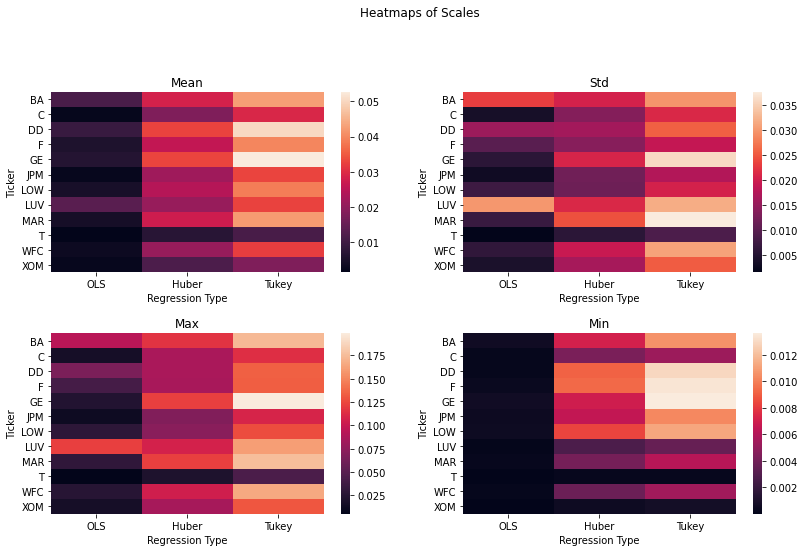

In [20]:
#we will then make a heatmap to show scale parameters attributes 
df_to_heat = (mean, std, _max, _min)
metrics = ['Mean', 'Std', 'Max', 'Min']
fig, ax = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Heatmaps of Scales');
fig.tight_layout(pad = 4.0)
coordinates = [[x, y] for x in [0,1] for y in [0,1]]
for n, metric in enumerate(df_to_heat): 
    x, y = coordinates[n]
    sns.heatmap(metric,  ax = ax[x,y])
    ax[x,y].set_title(metrics[n])
    ax[x,y].set_xlabel('Regression Type')
    ax[x,y].set_ylabel('Ticker')
    

$\quad$ From the graph above, we see a variety of metrics which represent different scale values that our regressions used. In clockwise order, we see that the mean values are right around 0.03 which makes sense for our data, we also see that OLS has much smaller values than compared with Huber and Tukey. We have that mean, std, max, and min are all showing the same pattern. OLS leaves the data more tightly clustered than Huber, and Tukey brings it the furthest apart by getting rid of the most outliers.  

$\quad$ This makes sense because the larger the scale parameter, the more spread out the distribution. In OLS, we don't get rid of any outliers at all, and we weight everything equally. Thus, we see that with OLS, the majority of the data seems very tightly clustered together (because we kept in the outliers), and thus, the scale parameter is very, very low. On the other hand, with Huber and Tukey, we have that they remove the outliers (by weighting them less), so in this case, we have that the remaining distribution of the data is more further spread out comparatively. 

$\quad$ We will now use a similar graphic to look at how the regressions performed out-of-sample based on our reported mean squared error out-of-sample.

In [39]:
#we want to get a similar heatmap for mean squared error
dict_of_errors = {}
regression_keys = ['OLS', 'Huber', 'Tukey']
regression_models = [OLS, Huber, Tukey]

for metric in ['Mean', 'Std', 'Min', 'Max']:
    
    metric_dict = {}
    
    for model in regression_models: 
        one_lst = []
        two_lst = []
        three_lst = []
        four_lst = []
        lst_of_lsts = [one_lst, two_lst, three_lst, four_lst]
        for ticker in data['ticker'].unique():

            for distance in [0,1,2,3]:
                model_name = model.iloc[0]['Regression Type']
                selection = model.loc[(model['Ticker'] == ticker) & (model['Distance'] == distance+1)]
                selection = selection['Mean Sq Error']
                
                if metric == 'Mean':
                    value = selection.mean()
                elif metric == 'Std':
                    value = selection.std()
                elif metric == 'Min':
                    value = selection.min()
                elif metric == 'Max':
                    value = selection.max()
                
                lst_of_lsts[distance].append(value)
        
        regression_metric_dict = {'One': one_lst,
                  'Two':two_lst,
                  'Three': three_lst,
                  'Four': four_lst}
        regression_metric_df = pd.DataFrame(regression_metric_dict, index=data['ticker'].unique())
        
        metric_dict[model_name] = regression_metric_df

    dict_of_errors[metric] = metric_dict

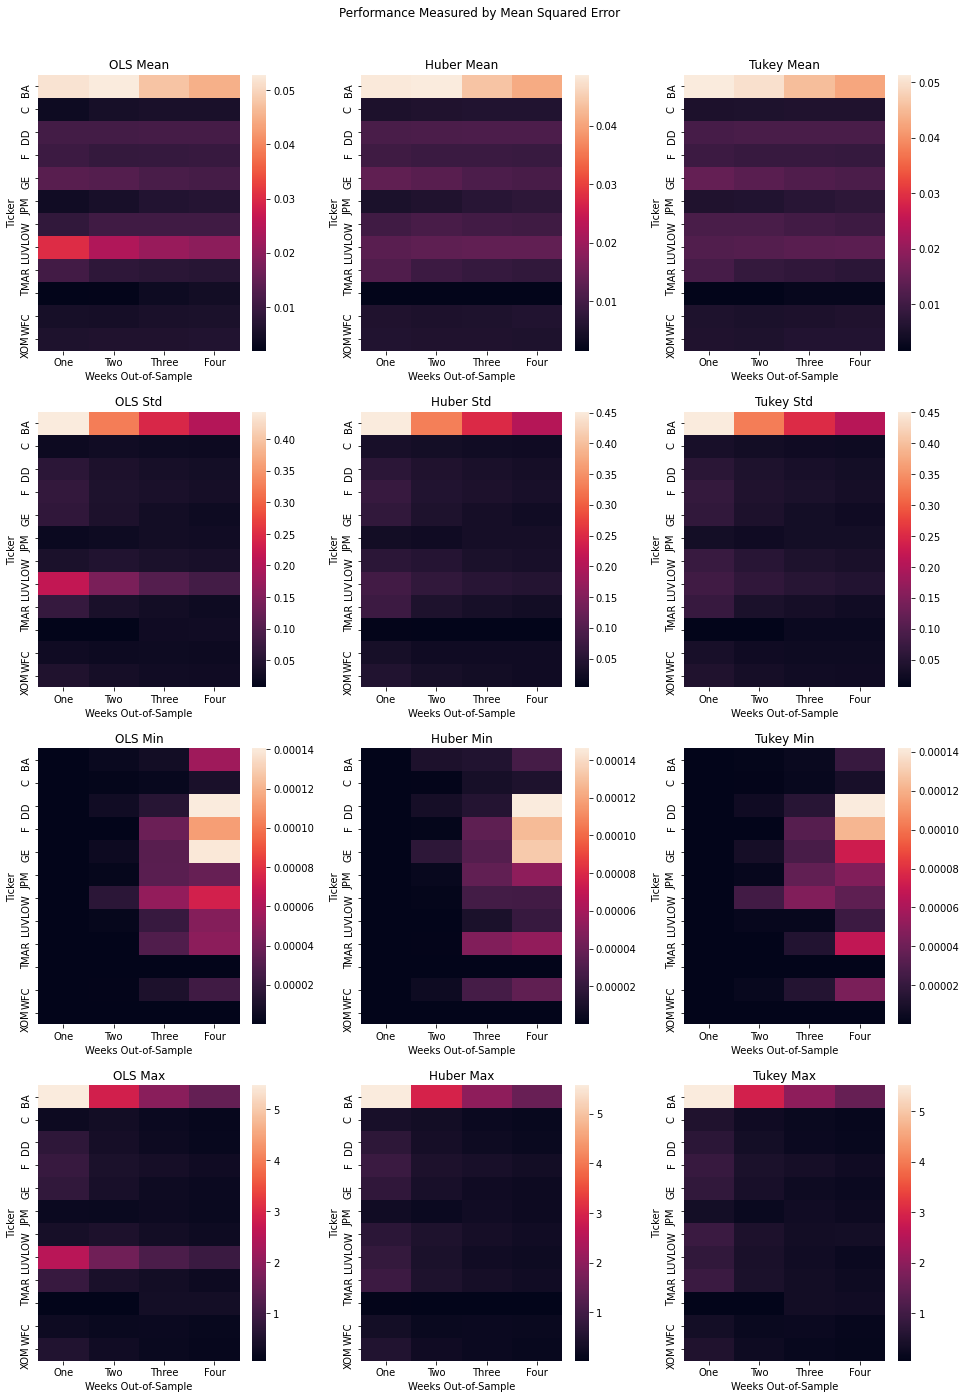

In [65]:
fig, ax = plt.subplots(4, 3, figsize=(14,20))
fig.suptitle('Performance Measured by Mean Squared Error');
fig.tight_layout(pad = 4.0)

regression_types = ['OLS', 'Huber', 'Tukey']
metrics = ['Mean', 'Std', 'Min', 'Max']
for n_y, y in enumerate(metrics): 
    for n_x, x in enumerate(regression_types):
        sns.heatmap(dict_of_errors[y][x], ax = ax[n_y, n_x])
        ax[n_y, n_x].set_title(x + ' ' + y)
        ax[n_y, n_x].set_xlabel('Weeks Out-of-Sample')
        ax[n_y, n_x].set_ylabel('Ticker')
        

$\quad$ Above, we have a heatmap which shows the Mean Squared Errors for regressions. They were all within the same ballpark of eachother, all bad at predicting BA. When we look at the means, we see that Huber and Tukey did slightly better than OLS, with Huber doing the best (see axises). Interestingly, we do have standard deviations of mean squared errors being lower for OLS than for Huber or Tukey. Their min and max mean squared errors were roughly the same. Although, mean squared errors between 0.01 and 0.04 when the average daily returns of the index were 0.01 is not that good. I would probably not use these regressions alone as a basis for a strategy, but the exercise does highlight the differences between the two. 

$\quad$ Below, I will discuss more in-depth how they handle outlier episodes in further detail.

In [222]:
print('Mean Daily Returns for CDS Index: ', r_index.mean())

Mean Daily Returns for CDS Index:  0.010492035412176203


In [168]:
#we want to generate data about the mean squared errors over time 
regression_models = [OLS, Huber, Tukey]
weds_to_use = np.array(wednesdays_strs)

dict_of_dfs_to_use = {}

for model in regression_models:
    model['Date'] = weds_to_use[model['Testing End'].values]
    model.set_index('Date', inplace=True)
    model.index = pd.to_datetime(model.index)
    model_name = model.iloc[0]["Regression Type"]
    
    avg_4 = []
    avg_3 = []
    avg_2 = []
    avg_1 = []
    std_4 = []
    std_3 = []
    std_2 = []
    std_1 = []
    
    stds = [std_1, std_2, std_3, std_4]
    avgs = [avg_1, avg_2, avg_3, avg_4]
    
    for date in model.index.unique():
        temp = model.loc[date]
        
        for distance in [1,2,3,4]:
            try:
                d_temp = temp.loc[(temp['Distance'] == distance)]
                d_temp = d_temp['Mean Sq Error']
                
                i_avg = d_temp.mean()
                i_std = d_temp.std()
                
                try: 
                    avgs[distance - 1].append(i_avg)
                except Exception as e: 
                    avgs[distance - 1].append(None)
                    print('Fail a: ', e)
                try:
                    stds[distance - 1].append(i_std)
                except Exception as e: 
                    stds[distance - 1].append(None)
                    print('Fail b: ', c)
                    
            except Exception as e: 
                print('Failure: ', e)
                avgs[distance - 1].append(None)
                stds[distance - 1].append(None)
                
    df = pd.DataFrame({
        'Avg 1' : avg_1, 
        'Avg 2' : avg_2, 
        'Avg 3' : avg_3, 
        'Avg 4' : avg_4, 
        'Std 1' : std_1, 
        'Std 2' : std_2, 
        "Std 3" : std_3, 
        'Std 4' : std_4
    }, index = model.index.unique())
    
    dict_of_dfs_to_use[model_name] = df


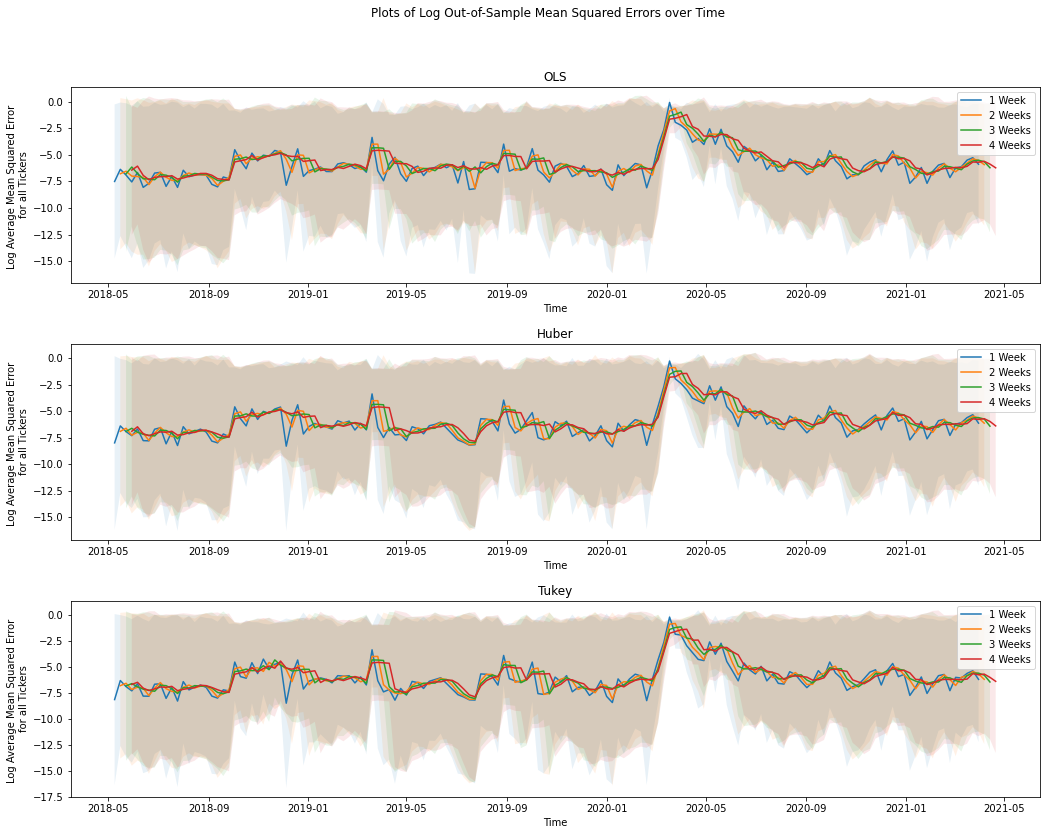

In [192]:
fig, ax = plt.subplots(3, figsize=(15,12))
fig.suptitle('Plots of Log Out-of-Sample Mean Squared Errors over Time')
fig.tight_layout(pad = 4.0)
cord = 0
for key, value in dict_of_dfs_to_use.items():
    value_log = np.log(value)
    value_log.index = pd.to_datetime(value_log.index)
    for week in ['1','2','3','4']:
        
        top = value_log['Avg ' + week] + value_log['Std '+week]
        bottom = value_log['Avg ' + week] - value_log['Std '+week]
        
        ax[cord].fill_between(value_log.index, top, bottom, alpha =0.1)
        ax[cord].plot(value_log['Avg '+week])
        ax[cord].legend(['1 Week', '2 Weeks', '3 Weeks', '4 Weeks'])
        ax[cord].set_xlabel('Time')
        ax[cord].set_ylabel('Log Average Mean Squared Error \nfor all Tickers')
        ax[cord].set_title(key)
    cord += 1

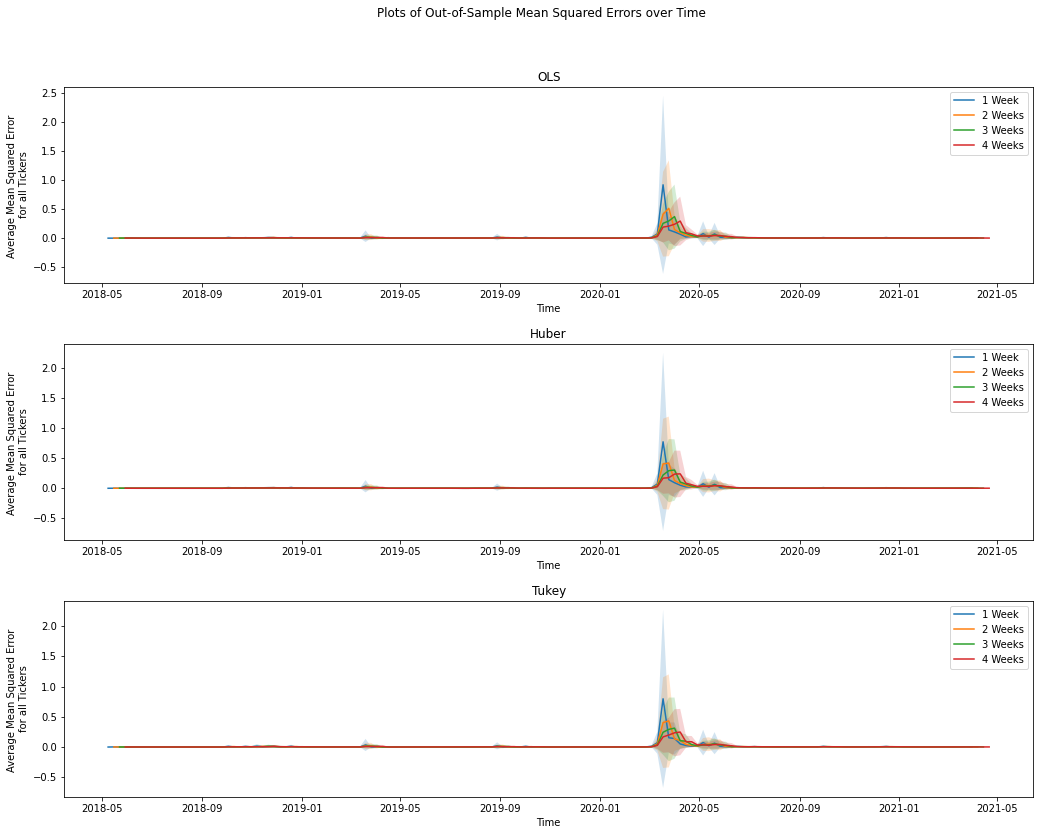

In [220]:
fig, ax = plt.subplots(3, figsize=(15,12))
fig.suptitle('Plots of Out-of-Sample Mean Squared Errors over Time')
fig.tight_layout(pad = 4.0)
cord = 0
for key, value in dict_of_dfs_to_use.items():
    value_log = (value)
    value_log.index = pd.to_datetime(value_log.index)
    for week in ['1','2','3','4']:
        
        top = value_log['Avg ' + week] + value_log['Std '+week]
        bottom = value_log['Avg ' + week] - value_log['Std '+week]
        
        ax[cord].fill_between(value_log.index, top, bottom, alpha =0.2)
        ax[cord].plot(value_log['Avg '+week])
        ax[cord].legend(['1 Week', '2 Weeks', '3 Weeks', '4 Weeks'])
        ax[cord].set_xlabel('Time')
        ax[cord].set_ylabel('Average Mean Squared Error \nfor all Tickers')
        ax[cord].set_title(key)
    cord += 1

$\quad$ There is a a lot of information above to take in. Above, for both log and non-log, I have generated three distinct graphs, one for each of the regressions. I have then plotted the average mean squared error across all equities for one, two, three, and four weeks out of sample. The cloud around the lines, corresponds to the standard deviation of the mean squared error for the equities on a given day. Although this graph is a bit complicated, it shows a couple very important things. 

$\quad$ First, most of the time, we were alright (see non-log), although we have huge standard deviations between equities (see log graph), we have pretty stable mean squared errors. Mean squared errors at log -7 or so for daily returns are not bad. During normal times, there are few strong outliers if any and so we see very consistent performance between all three.

$\quad$ However, as we can clearly see from the non-log graph, there was an episode in early to mid 2020, for which our errors were horrible. We will investigate this further below. It obvious correlates with the market events which we can see and makes sense given the data. See the graph below for a more detailed looked at the episode, but, ever so slightly do we see that Huber and Tukey have lower standard deviations for their errors, and they seem to be better and moderately quicker at returning to normal standard errors (see axises). This happens because they discount the weights of strong outlier events compared to OLS. 

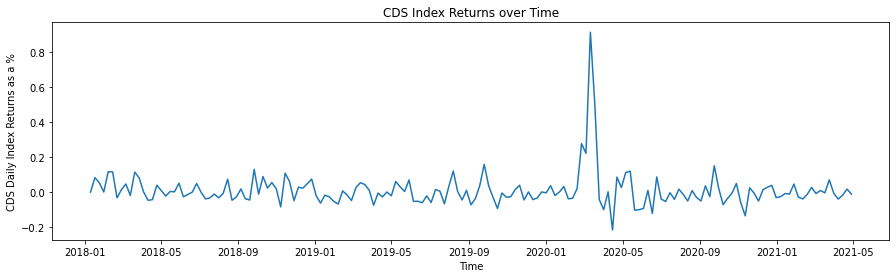

In [216]:
r_index.index = pd.to_datetime(r_index.index)
ax, fig = plt.subplots(1, figsize = (15,4))
plt.plot(r_index);
plt.xlabel('Time')
plt.ylabel('CDS Daily Index Returns as a %')
plt.title('CDS Index Returns over Time');

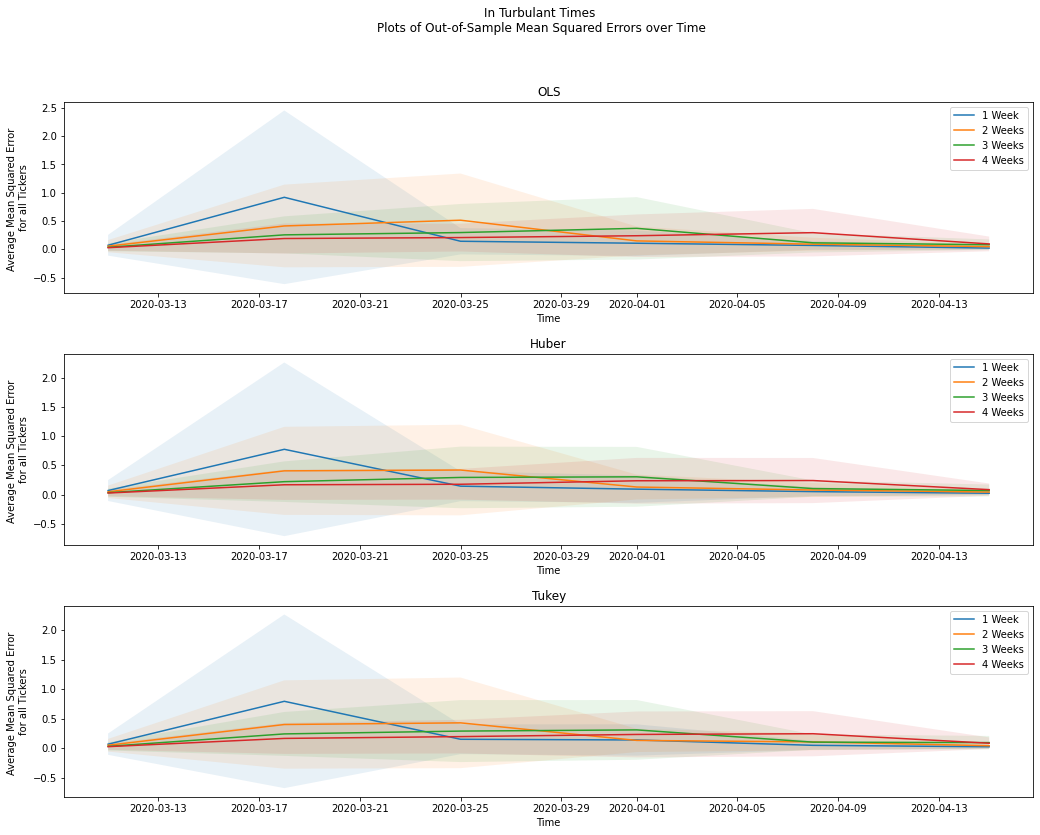

In [221]:
fig, ax = plt.subplots(3, figsize=(15,12))
fig.suptitle('In Turbulant Times \nPlots of Out-of-Sample Mean Squared Errors over Time')
fig.tight_layout(pad = 4.0)
cord = 0
for key, value in dict_of_dfs_to_use.items():
    value_log = value.loc['2020-03-05':'2020-04-21']
    value_log.index = pd.to_datetime(value_log.index)
    for week in ['1','2','3','4']:
        
        top = value_log['Avg ' + week] + value_log['Std '+week]
        bottom = value_log['Avg ' + week] - value_log['Std '+week]
        
        ax[cord].fill_between(value_log.index, top, bottom, alpha =0.1)
        ax[cord].plot(value_log['Avg '+week])
        ax[cord].legend(['1 Week', '2 Weeks', '3 Weeks', '4 Weeks'])
        ax[cord].set_xlabel('Time')
        ax[cord].set_ylabel('Average Mean Squared Error \nfor all Tickers')
        ax[cord].set_title(key)
    cord += 1

$\quad$ In conclusion, the results between the three were quite similar. This makes sense given that we only ever use 16 data points to predict the coming weeks, and for the majority of the time, there are few outliers. In the episode when we did have very strong outliers, we saw that they performed as expected. The robust models discounting their belief in the outliers while OLS moved more quickly to trust them and as a result had higher error in out-of-sample forecasting. 
